In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.applications import ResNet50
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score
import seaborn as sns
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
# Constants
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 40
CHANNELS = 3
NUM_CLASSES = 11 # Adjust this based on your dataset
DATASET_PATH = "/content/drive/MyDrive/Vehicle Dataset"

In [9]:
# Load dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    seed = 123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2364 files belonging to 11 classes.


In [10]:
# Get class names
class_names = dataset.class_names
class_names

['Honda City 2000-2005',
 'Nissan X-trail 2014-2016',
 'Suzuki Swift 2000-2006',
 'Suzuki Swift 2017-2020',
 'Suzuki Wagon R Stringary 2014-2016',
 'Suzuki Wagon R Stringary 2017-2018',
 'Toyota Alion 240 2001-2007',
 'Toyota Alion 260 2007-2010',
 'Toyota Axio 2012-2015',
 'Toyota Axio 2015-2019',
 'Toyota Premio 2007-2015']

In [11]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[ 0  9  4  5  8 10  2  6  4  2  7  3  0  7  3  1  8  2 10  0  4 10  9  2
  2  0  8  5  5  9  4  0]


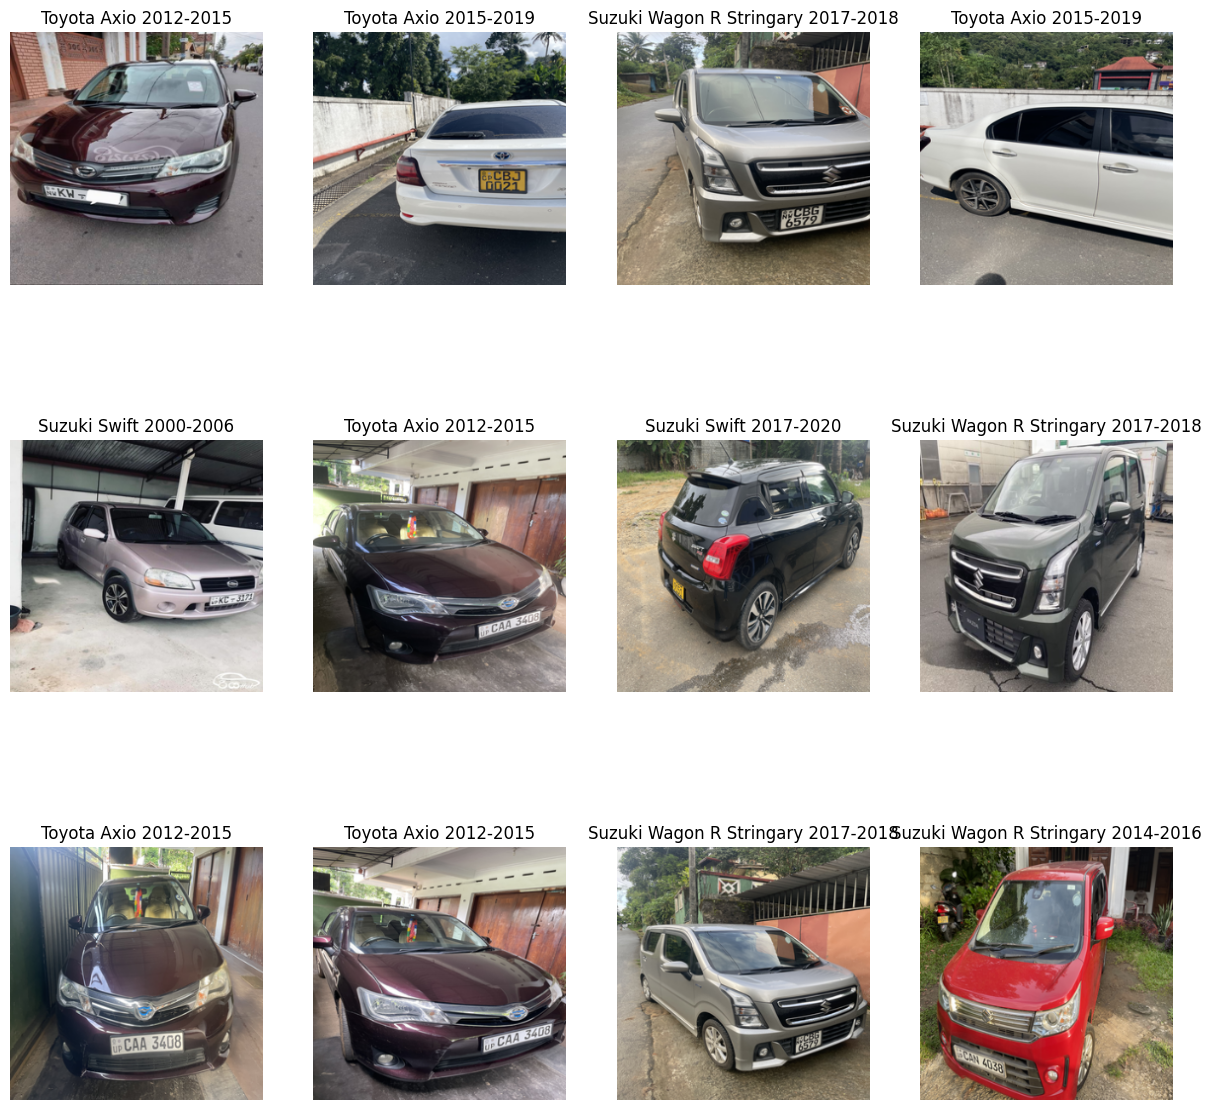

In [12]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

Function to Split Dataset
Dataset should be bifurcated into 3 subsets, namely:

Training: Dataset to be used while training
Validation: Dataset to be tested against while training
Test: Dataset to be tested against after we trained a model

In [13]:
# Split dataset into train, validation, and test sets
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [14]:
len(train_ds)

59

In [15]:
len(val_ds)

7

In [16]:
len(test_ds)

8

In [17]:
# Cache, Shuffle, and Prefetch the Dataset
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Building the Model

In [18]:
# Creating a Layer for Resizing and Normalization
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

In [19]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [20]:
# Applying Data Augmentation to Train Dataset
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Model Architecture

In [21]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 11

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 11)                    │             715 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 184,267 (719.79 KB)

 Trainable params: 184,267 (719.79 KB)

 Non-trainable params: 0 (0.00 B)

Compiling the Model

In [23]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [24]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=40,
)

Epoch 1/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 484s 714ms/step - accuracy: 0.1121 - loss: 2.3813 - val_accuracy: 0.1339 - val_loss: 2.3560
Epoch 2/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 21s 351ms/step - accuracy: 0.1750 - loss: 2.2601 - val_accuracy: 0.2768 - val_loss: 2.1345
Epoch 3/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 21s 363ms/step - accuracy: 0.2441 - loss: 2.0818 - val_accuracy: 0.3750 - val_loss: 1.8254
Epoch 4/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 20s 346ms/step - accuracy: 0.4156 - loss: 1.7793 - val_accuracy: 0.3304 - val_loss: 1.8716
Epoch 5/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 22s 370ms/step - accuracy: 0.4376 - loss: 1.6639 - val_accuracy: 0.5312 - val_loss: 1.5285
Epoch 6/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 20s 344ms/step - accuracy: 0.5376 - loss: 1.4913 - val_accuracy: 0.5982 - val_loss: 1.4091
Epoch 7/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 22s 370ms/step - accuracy: 0.6517 - loss: 1.1940 - val_accuracy: 0.5670 - val_loss: 1.4206
Epoch 8/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 21s 351ms/step - accuracy: 0.6975 - loss: 1.0581 - val_acc

In [25]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.8910 - loss: 0.3803


In [26]:
scores

[0.3068104386329651, 0.90234375]

In [27]:
history

In [28]:
history.params

{'verbose': 1, 'epochs': 40, 'steps': 59}

In [29]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [30]:
type(history.history['loss'])

list

In [31]:
len(history.history['loss'])

40

In [32]:
history.history['loss'][:5] # show loss for first 5 epochs

[2.37255597114563,
 2.1932871341705322,
 2.014796495437622,
 1.765338659286499,
 1.652306079864502]

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

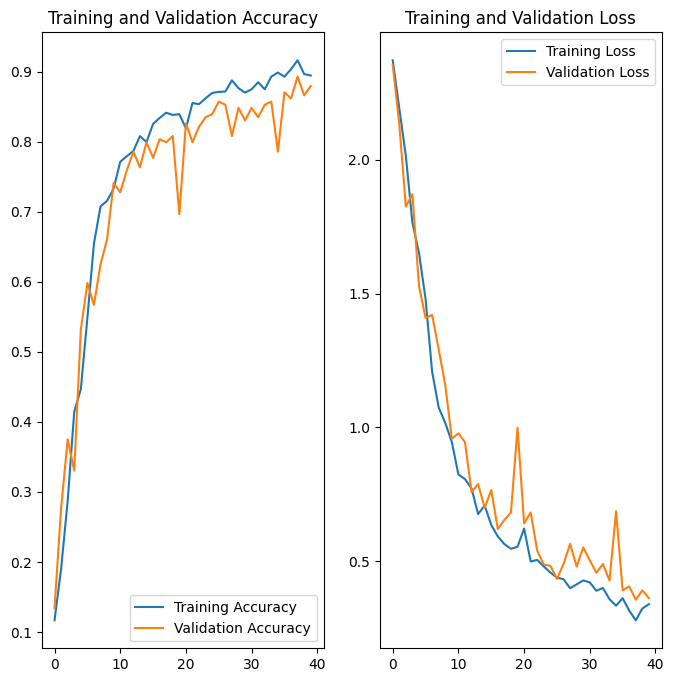

In [34]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Nissan X-trail 2014-2016
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
predicted label: Nissan X-trail 2014-2016


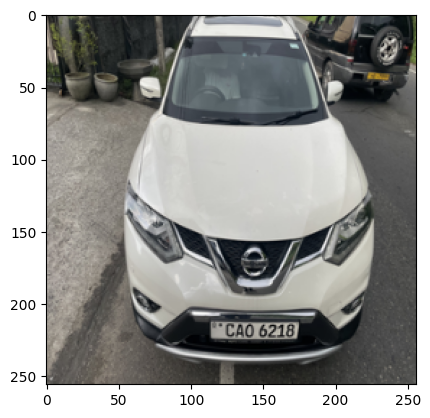

In [35]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [36]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


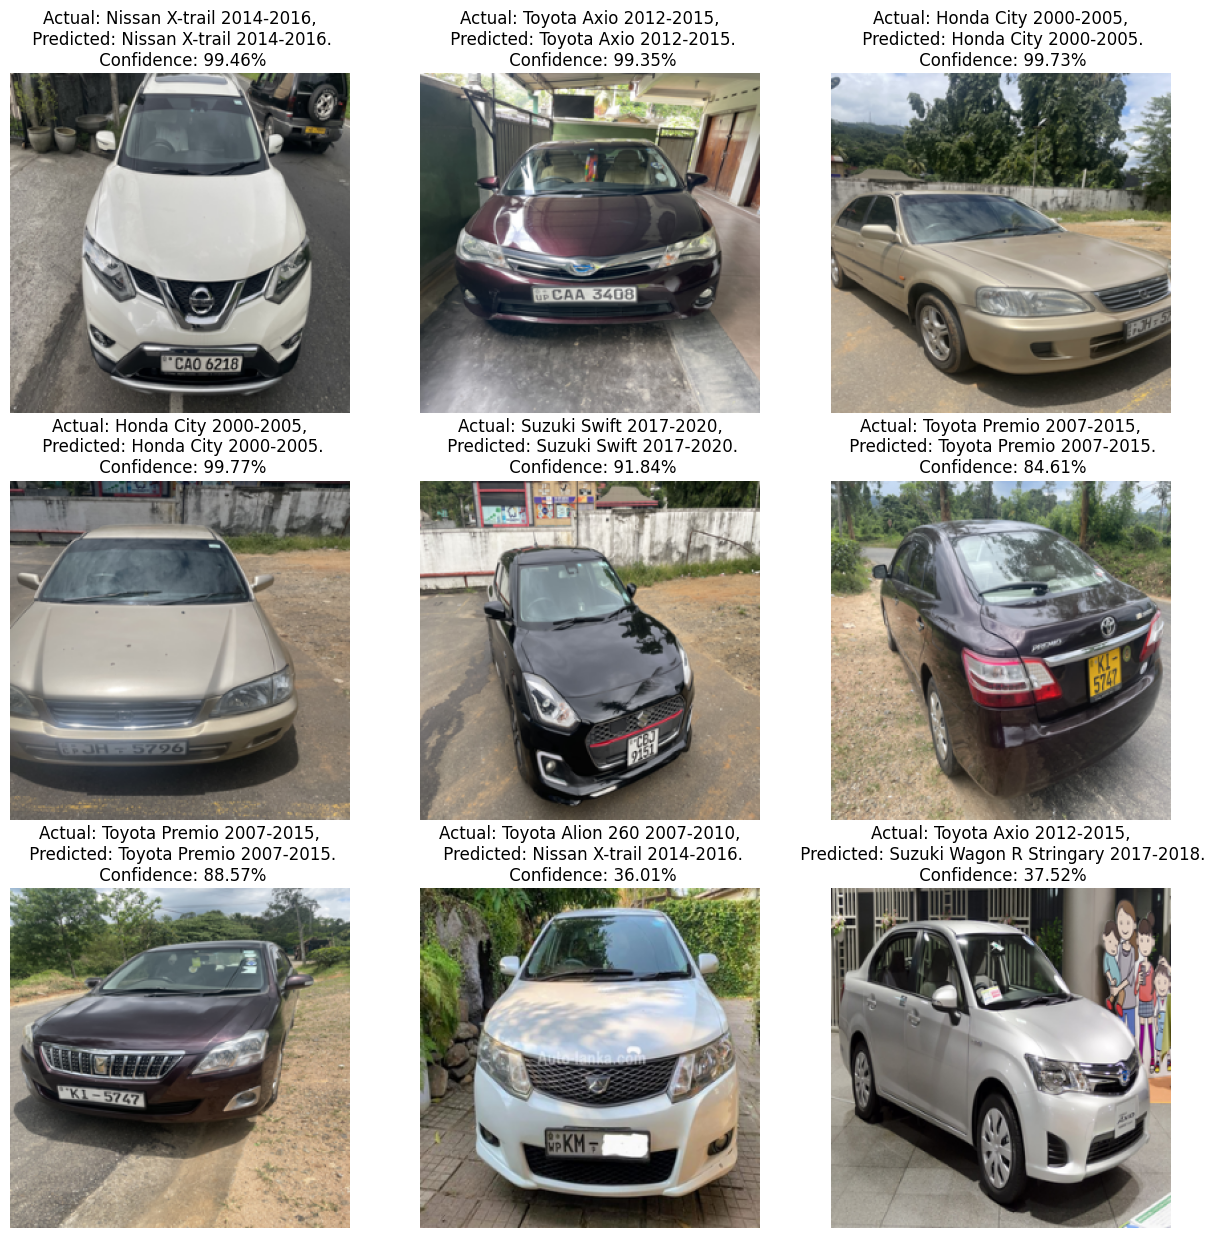

In [37]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


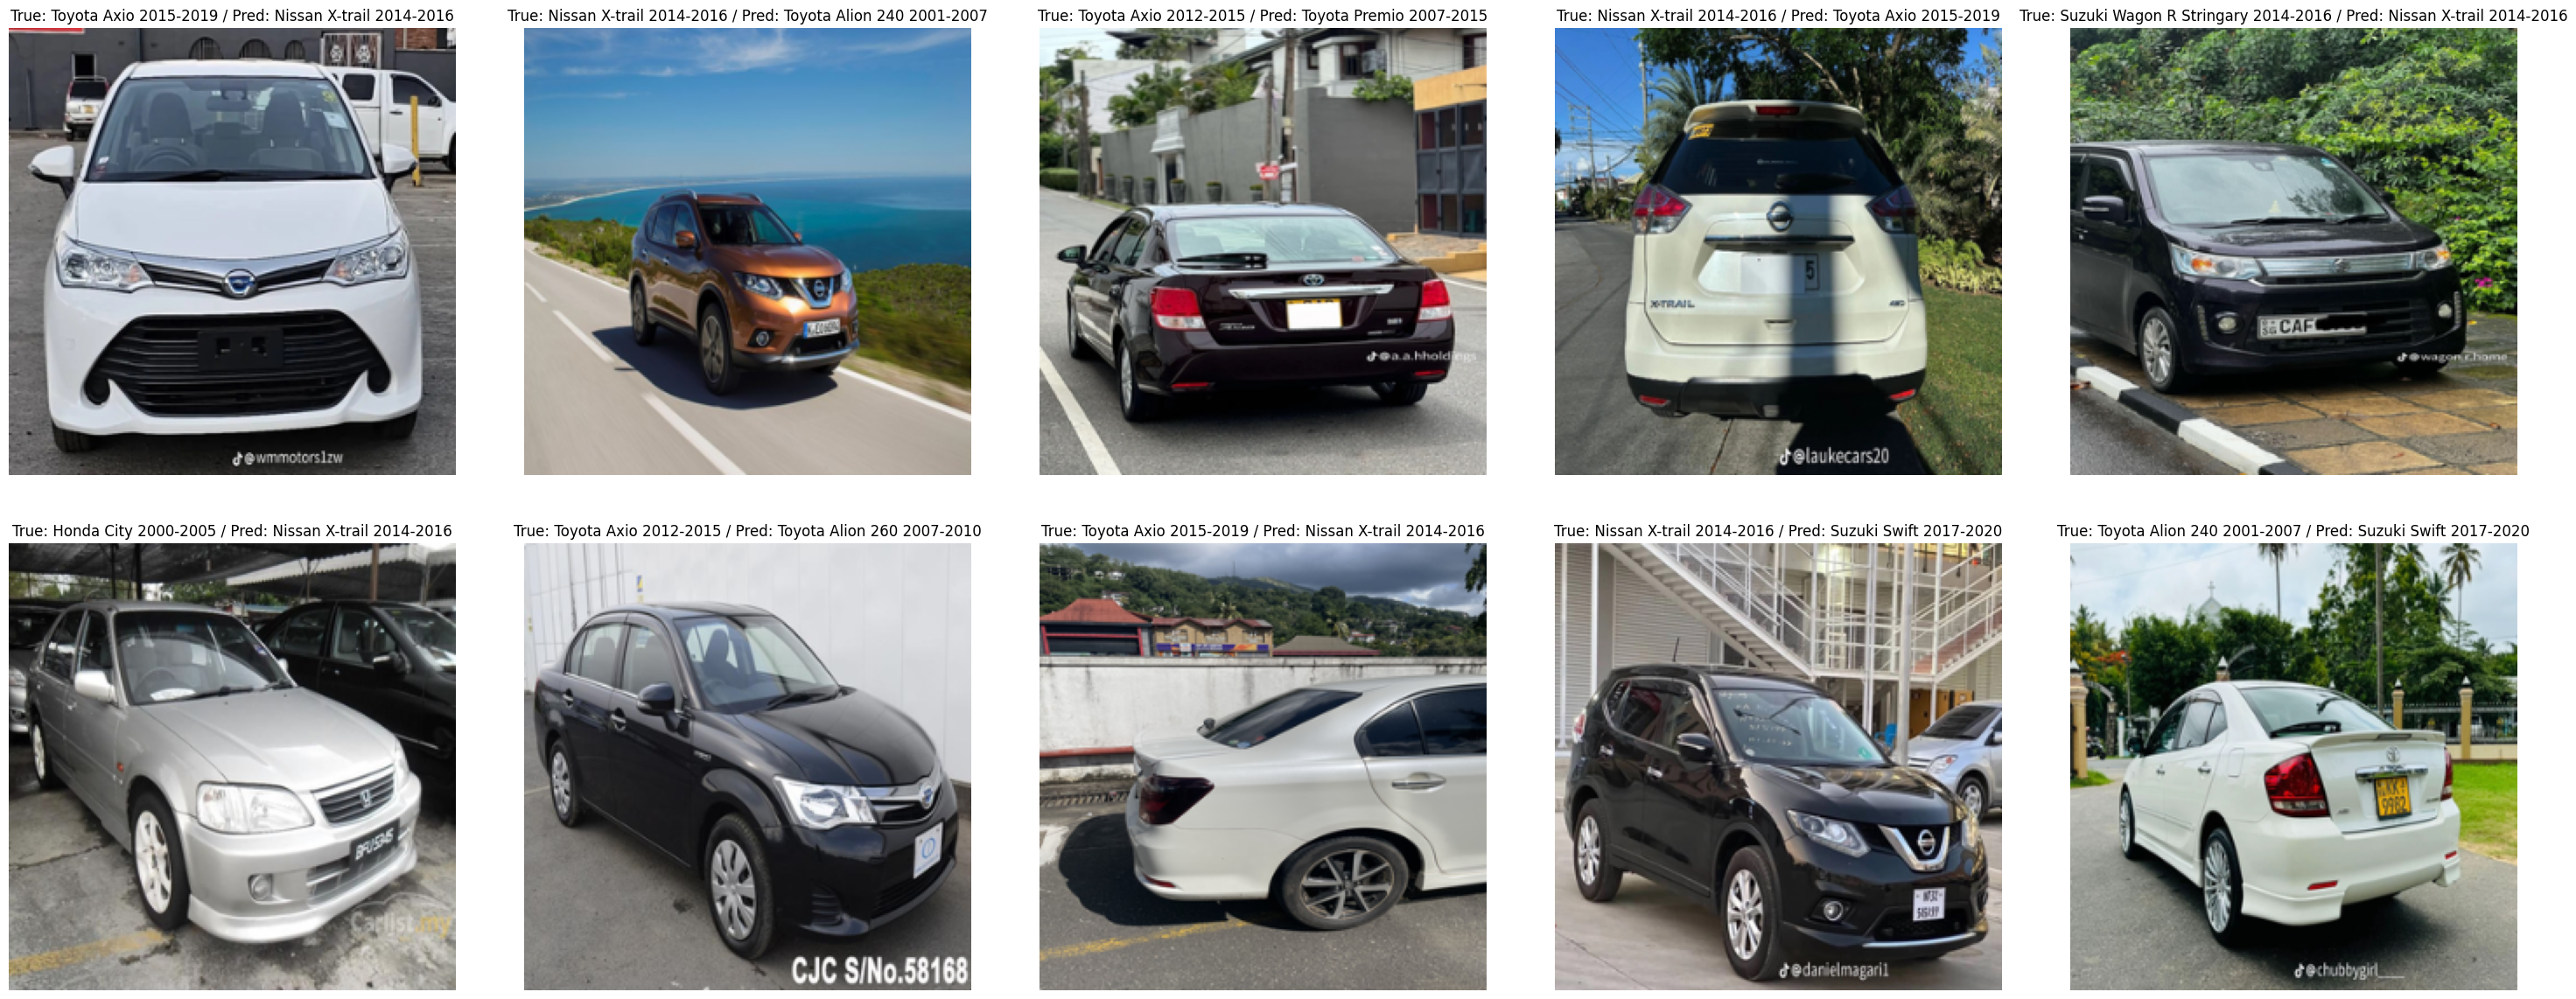

In [38]:
# Visualizing misclassified images
def plot_misclassified_images(test_ds, model):
    misclassified_images = []
    true_labels = []
    pred_labels = []

    for images, labels in test_ds:
        preds = model.predict(images)
        pred_labels.extend(np.argmax(preds, axis=1))
        true_labels.extend(labels.numpy())
        for i, label in enumerate(labels):
            if np.argmax(preds[i]) != label:
                # Rescale images to 0-1 for plotting
                img_rescaled = (images[i].numpy() - np.min(images[i].numpy())) / (np.max(images[i].numpy()) - np.min(images[i].numpy()))
                misclassified_images.append((img_rescaled, label, np.argmax(preds[i])))

        if len(misclassified_images) >= 10:
            break

    plt.figure(figsize=(30, 30))
    for i, (image, true_label, pred_label) in enumerate(misclassified_images[:10]):
        plt.subplot(5, 5, i + 1)
        plt.imshow(image)
        plt.title(f"True: {class_names[true_label]} / Pred: {class_names[pred_label]}")
        plt.axis('off')

    plt.tight_layout(pad=4.0)
    plt.show()

plot_misclassified_images(test_ds, model)


In [39]:
from tensorflow.keras.preprocessing import image

def load_and_preprocess_image(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize image
    return img_array

def predict_image(img_path, model):
    img_array = load_and_preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    class_name = class_names[predicted_class[0]]
    return class_name

# Example usage
img_path = "/content/drive/MyDrive/Vehicle Dataset/Suzuki Swift 2017-2020/IMG_6428.png"
predicted_label = predict_image(img_path, model)
print(f'Predicted Label: {predicted_label}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted Label: Suzuki Wagon R Stringary 2014-2016


In [40]:
model.save('vehicle_model.h5')


In [41]:
model.save('my_model.keras')